### Kaggle username - alexanderzaburdaev

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Подготовка датасета

In [3]:
#Преобразуем датасет в датафрейм
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')
#train_dataset.head()

# Преобразование признаков

In [4]:
train_dataset.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

# Функции по обработке датасета(Через ООП делать думаю нет смысла)

In [5]:
def fix_outliers(data):
        data['HouseYear'].loc[data['HouseYear'] > 2020] = 2020
        
        data['Rooms_outlier'] = 0
        data.loc[(data['Rooms'] == 0) | (data['Rooms'] >= 5), 'Rooms_outlier'] = 1
        data.loc[data['Rooms'] == 0, 'Rooms'] = 1
        data.loc[data['Rooms'] >= 5, 'Rooms'] = data['Rooms'].median()
        
        if 'Healthcare_1' in data.columns:
            data.drop('Healthcare_1', axis=1, inplace=True)
        
        data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].median())
        data['LifeSquare'].loc[(data['LifeSquare'] > data['LifeSquare'].quantile(0.95))] = data['LifeSquare'].median()
        
        return data
    
def add_features(data, y=None):
        
        binary_to_numbers = {'A': 0, 'B': 1}
        data['Ecology_2'] = data['Ecology_2'].replace(binary_to_numbers)
        data['Ecology_3'] = data['Ecology_3'].replace(binary_to_numbers)
        data['Shops_2'] = data['Shops_2'].replace(binary_to_numbers)
        
        district_size = data['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        data = data.merge(district_size, on='DistrictId', how='left')
        data['IsDistrictLarge'] = (data['DistrictSize'] > 100).astype(int)
        
        bins = [0, 1941, 1945, 1980, 2000, 2010, data['HouseYear'].max()]
        data['HouseYearCat'] = pd.cut(data['HouseYear'], bins=bins, labels=False)
        return data

In [6]:
X_fixed = fix_outliers(train_dataset[list(train_dataset.columns)]).copy()
Xf = add_features(X_fixed, train_dataset['Price']).copy()

In [32]:
Xf.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,DistrictSize,IsDistrictLarge,HouseYearCat
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,0,0,1,0,91,0,2
1,15856,74,2.0,69.263183,32.925087,1.0,6,1.0,1977,0.075779,...,6,1437,3,0,2,1,0,61,0,2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,5,5,1,0,2,0,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,3,3,1,0,49,0,4
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,0,0,0,0,391,1,5


# Строим модель

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

X = Xf[list(Xf.loc[:, ((Xf.columns != 'Price') & (Xf.columns != 'Id'))].columns)]
Y = Xf[['Price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=21)

#Модель проверялась на данных, на которых обучалась, отсюда и такое большое значение r2
model = RandomForestRegressor(n_estimators=100, random_state=21, criterion='mse')
model.fit(X, Y)

0.9572340378517342

# Проверяем эффективность и заливаем в файл

In [9]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.449858
18,DistrictSize,0.222748
13,Social_3,0.051664
8,Ecology_1,0.033495
3,LifeSquare,0.032251
7,HouseYear,0.032093
0,DistrictId,0.028171
5,Floor,0.027233
12,Social_2,0.024147
6,HouseFloor,0.023011


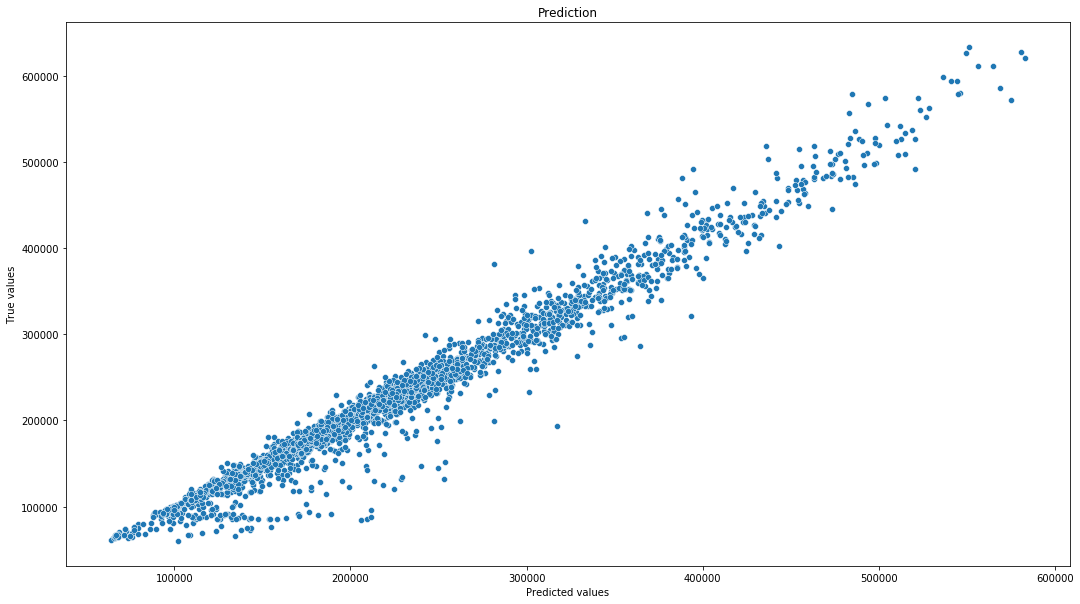

In [31]:
plt.figure(figsize=(18, 10))
sns.scatterplot(x=model.predict(X_test), y=np.reshape(np.array(Y_test), (3300, )))
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Prediction')
plt.show()

In [13]:
X_fixed = fix_outliers(test_dataset[list(test_dataset.columns)]).copy()
Xf = add_features(X_fixed).copy()
Xfinal = Xf[Xf.columns[1:]]
preds = model.predict(Xfinal)
submit['Price'] = preds
submit.to_csv('rf_submit.csv', index=False)